## DM-28157 Frequency cutting based on estimated Gaussian radius


 * We generate the PSF on the padded size, to avoid the window function effect
 * Now the windowing oscillation disappears but in the tails we got numerical noise and nan-s for biting zeroes
 * We conclude that reaching of the limiting value of fc1, fc2 cannot be assumed even here (it depends on the delta sigmas)
 * Replacement with a "similar" value estimation is better than nothing but not the best, the step gives nice ringing structure in general -> TODO: get a model solution for the replaced values
 * Nevertheless, this ringing structure is more localized than the generic patterns

### Notations

$fc_1$, $fc_2$: Matching kernels in Fourier space.
$c_1$, $c_2$: Matching kernels for the input images A, B in image space. 

$P_d$ : the PSF of the difference image, the result of the PSF matching for both images.

$\sigma_1$, $\sigma_2$: The PSF sigma (width) of Gaussian image PSFs in _image space_.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
%run -b -i "array_freq_cut.py"
%run -b -i "TwoD_gaussian_in_freq_space.py"

In [2]:
from lsst.ip.diffim.zogy import ZogyTask, ZogyConfig
config = ZogyConfig()
config.scaleByCalibration = False
task = ZogyTask(config=config)

Create a test mask array

In [3]:
# We assume wSig1 > wSig2 in the limit values here
wSig1 = 3.31
wSig2 = 3.3
fourPiSq = 4. * np.pi * np.pi

In [4]:
fr1, fr2 = calculateCutFrequencies(wSig1, wSig2, 100, 100, limit=0.999999)
print(fr1, fr2)
print(fr1 * 1024, fr2 * 1024)
frp1 = calculateGaussianCutFrequency(wSig1, limit=0.999999)
frp2 = calculateGaussianCutFrequency(wSig2, limit=0.999999)
print (frp1, frp2)
print (frp1 * 1024, frp2 * 1024)

0.808 0.808
827.392 827.392
0.232 0.232
237.568 237.568


## 1024x1024 PSFs and FFTd
Generate the PSFs directly at their padded size.

In [5]:
pA = calculate2dGaussianArray(1024, 1024, wSig1, fftShift=True)
# pA = task.padCenterOriginArray(A,(1024,1024))
psf1 = np.fft.fft2(pA)
pB = calculate2dGaussianArray(1024, 1024, wSig2, fftShift=True)
# pB = task.padCenterOriginArray(B,(1024,1024))
psf2 = np.fft.fft2(pB)

<IPython.core.display.Javascript object>


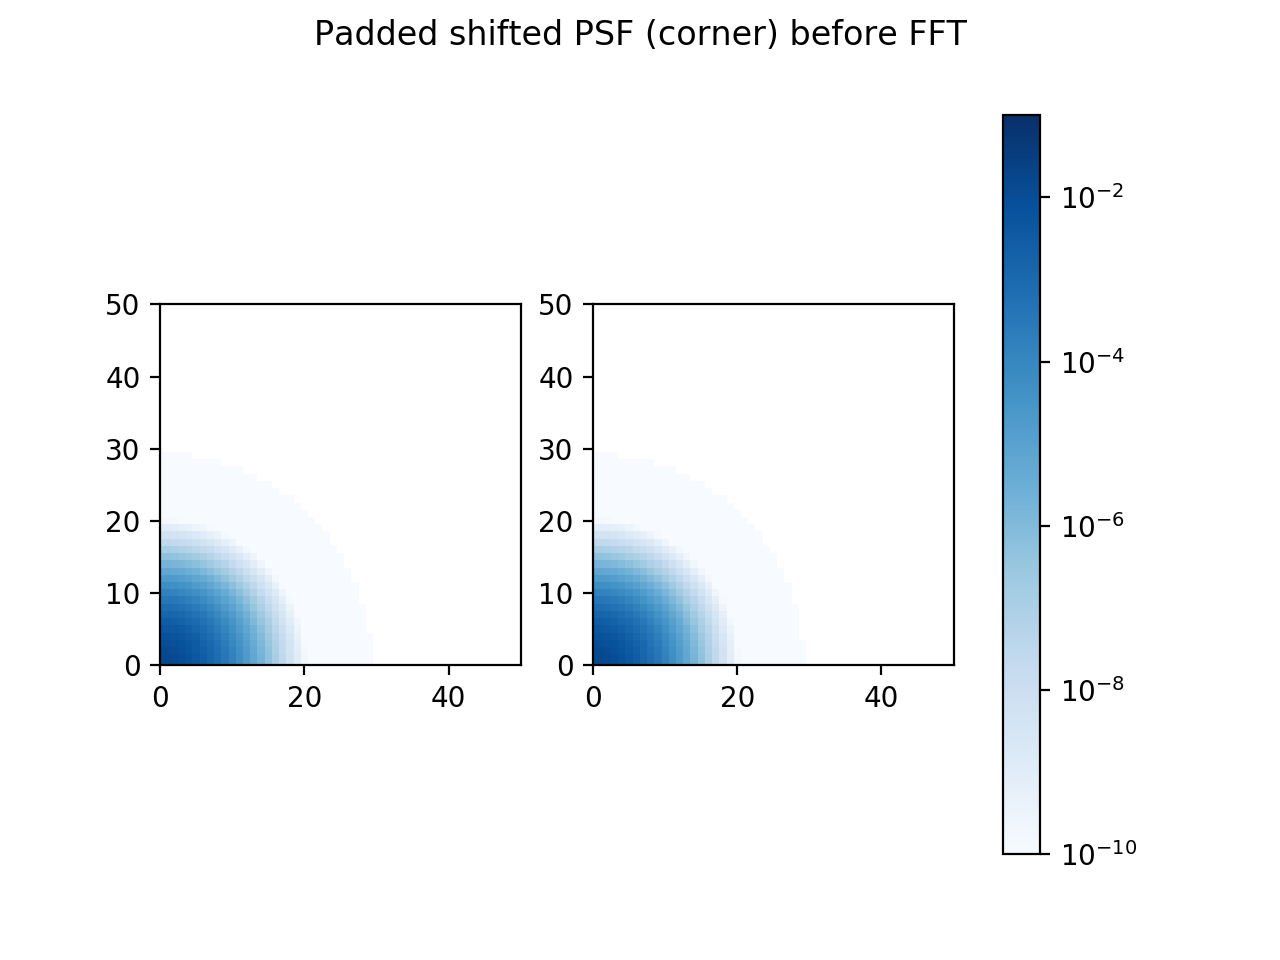

Text(0.5, 0.98, 'Padded shifted PSF (corner) before FFT')

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
cs = ax1.imshow(pA, origin='bottom', interpolation='none',  cmap='Blues',
               norm=matplotlib.colors.LogNorm(vmin=1e-10,vmax=0.1))
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.imshow(pB, origin='bottom', interpolation='none',  cmap='Blues',
               norm=matplotlib.colors.LogNorm(vmin=1e-10,vmax=0.1))
fig.colorbar(cs, ax=[ax1, ax2])
ax1.set_xlim(0, 50)
ax1.set_ylim(0, 50)
ax2.set_xlim(0, 50)
ax2.set_ylim(0, 50)
fig.suptitle("Padded shifted PSF (corner) before FFT")

<IPython.core.display.Javascript object>


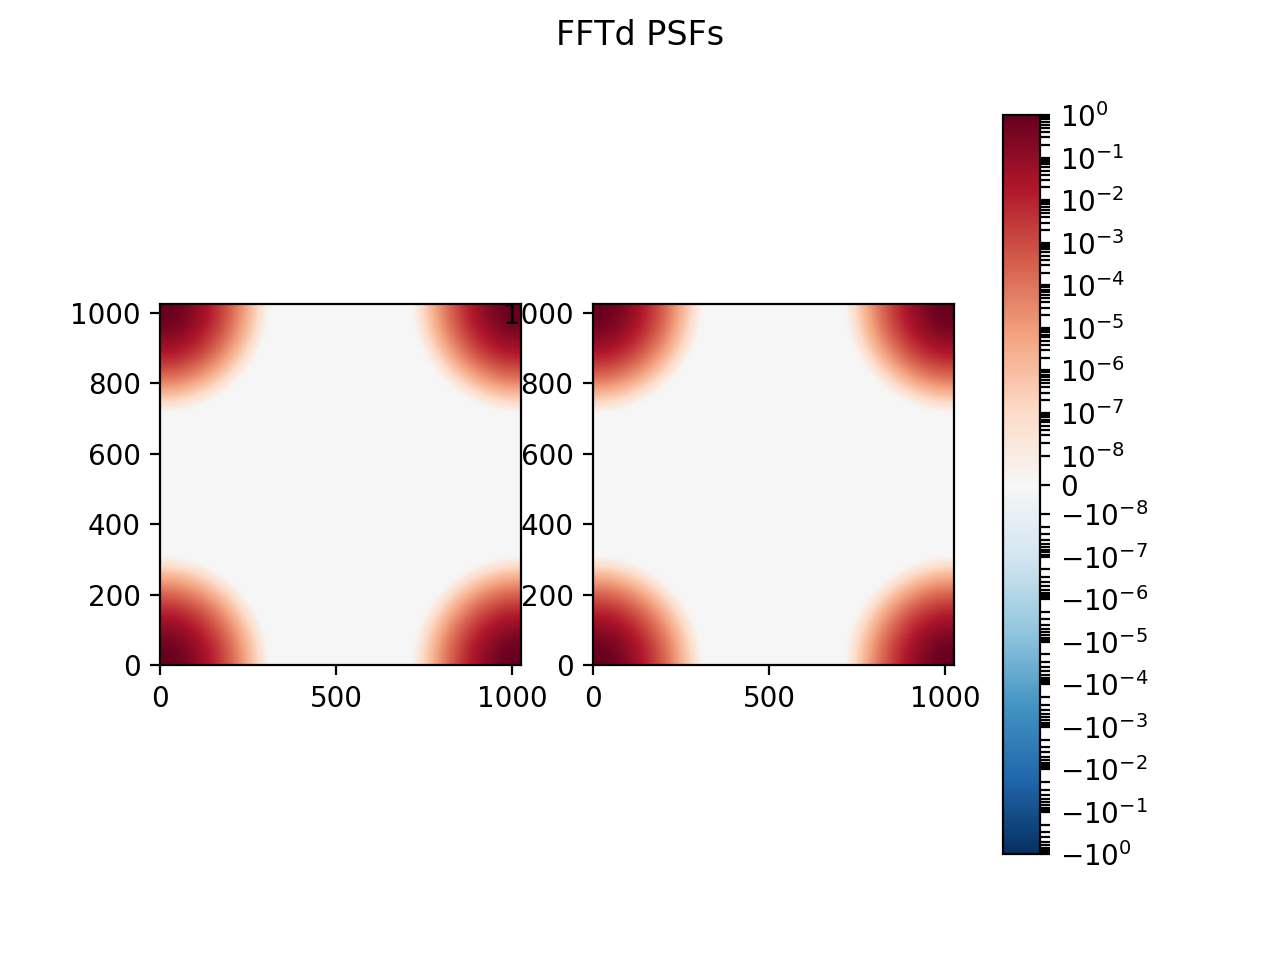

Text(0.5, 0.98, 'FFTd PSFs')

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
cs = ax1.imshow(psf1.real, origin='bottom', interpolation='none',  cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8,vmin=-1,vmax=1))
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.imshow(psf2.real, origin='bottom', interpolation='none',  cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-8,vmin=-1,vmax=1))
fig.colorbar(cs, ax=[ax1, ax2])
fig.suptitle("FFTd PSFs")

There are some small negative values around in the frequency space PSFs.

In [8]:
# Noise variance in the images
varMean1 = 100
varMean2 = 100
F1 = 1.
F2 = 1. 
var1F2Sq = varMean1*F2*F2
var2F1Sq = varMean2*F1*F1
FdDenom = np.sqrt(var1F2Sq + var2F1Sq)  # one number
# We need reals for comparison, also real operations are usually faster
# Psf absolute squared
psfAbsSq1 = np.real(np.conj(psf1)*psf1)
psfAbsSq2 = np.real(np.conj(psf2)*psf2)
sDenom = var1F2Sq*psfAbsSq2 + var2F1Sq*psfAbsSq1  # array, eq. (12)
# sDenom close to zero check here in the code, here we ignore, we won't hit division by zero
denom = np.sqrt(sDenom)  # array, eq. (13)

sDenom: The squared denominator in the difference image calculation

In [9]:
fPd = FdDenom*psf1*psf2/denom  # Psf of D eq. (14)
fc1 = psf2/denom
fc2 = psf1/denom

/ssd/gkovacs/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/ssd/gkovacs/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/ssd/gkovacs/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
print(FdDenom)

14.142135623730951


Check all are real.


We've got NaN's that are not equal to zero!

In [11]:
print(np.all(fPd.imag == 0), np.all(fc1.imag == 0), np.all(fc2.imag == 0))

False False False


<IPython.core.display.Javascript object>


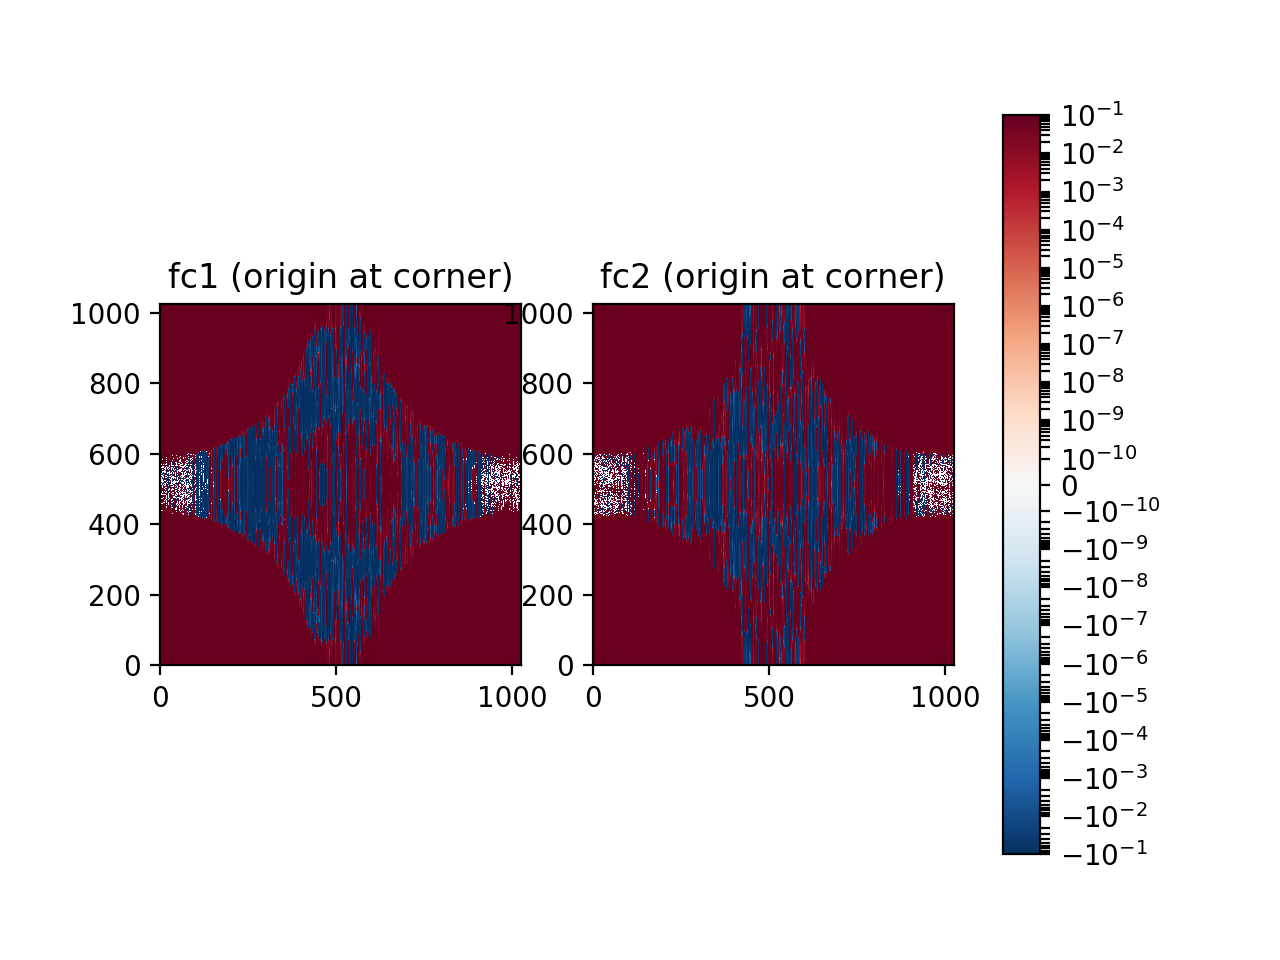

fc1 min nan
fc1 max nan
fc2 min nan
fc2 max nan


In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
cs = ax1.imshow(fc1.real, origin='bottom', interpolation='none', cmap='RdBu_r',
                norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
ax1.set_title("fc1 (origin at corner)")
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.imshow(fc2.real, origin='bottom', interpolation='none', cmap='RdBu_r',
                norm=matplotlib.colors.SymLogNorm(linthresh=1e-10,vmin=-0.1,vmax=0.1))
ax2.set_title("fc2 (origin at corner)")
fig.colorbar(cs, ax=[ax1, ax2])
print(f"fc1 min {np.min(fc1.real)}")
print(f"fc1 max {np.max(fc1.real)}")
print(f"fc2 min {np.min(fc2.real)}")
print(f"fc2 max {np.max(fc1.real)}")

White pixels mark missing points (nans).

The matching kernel for the wider input PSF

<IPython.core.display.Javascript object>


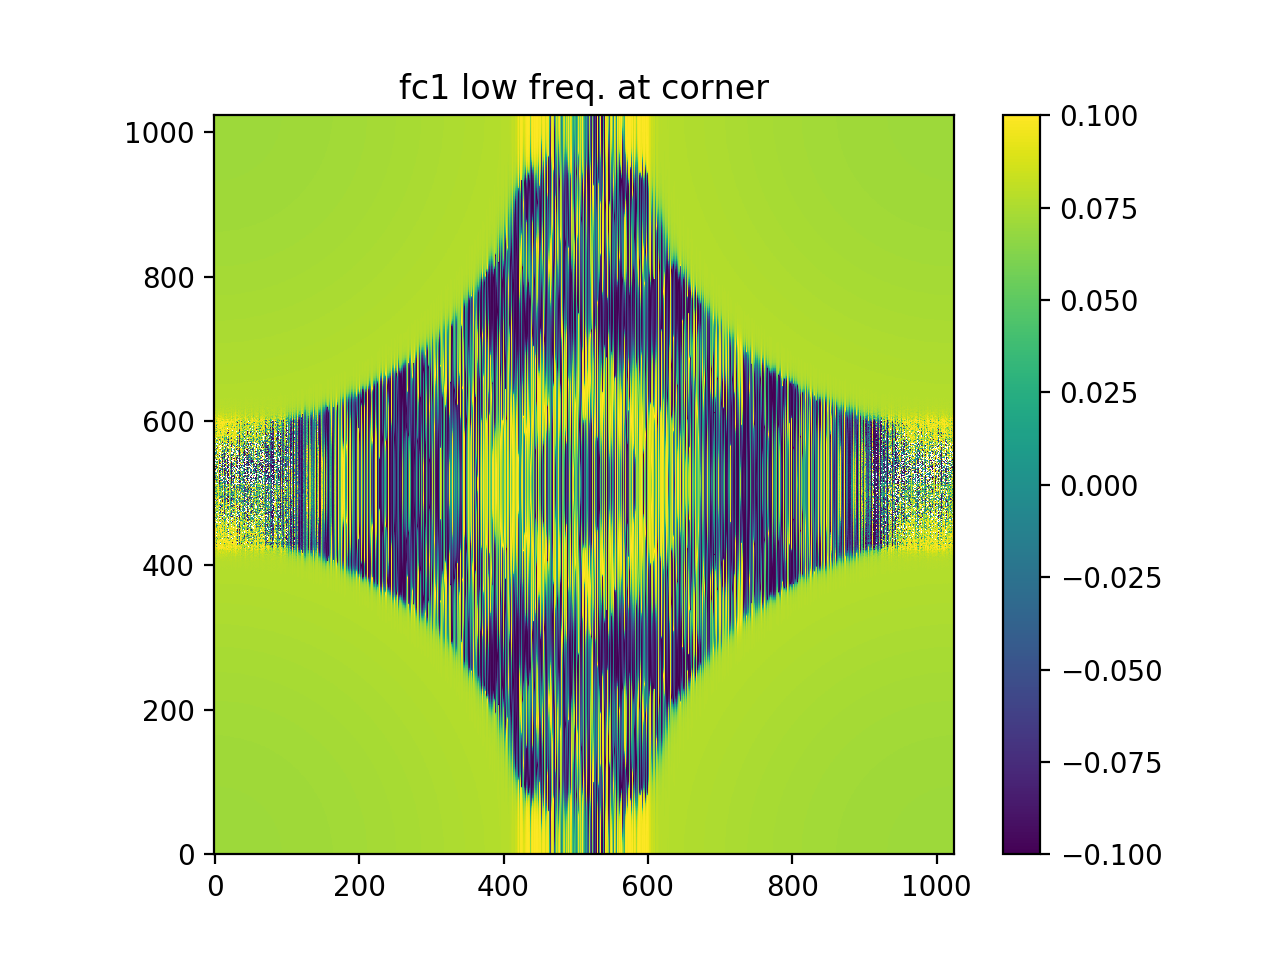

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc1.real, origin='bottom', interpolation='none')
ax1.set_title("fc1 low freq. at corner")
fig.colorbar(cs)

In [14]:
r = np.minimum(fr1, frp2)
rN = np.minimum(fr1, frp2) * 1024
freqFlt1 = makeEllipseQuartersMaskArray((1024, 1024), rN , rN)
sqDiffWidth = wSig1*wSig1 - wSig2*wSig2
flim1 = 1./(F1 * np.sqrt(varMean1/(F1*F1) + varMean2/(F2*F2) * np.exp(-fourPiSq*sqDiffWidth*r)))
flim11 = 1./(F1 * np.sqrt(varMean1/(F1*F1) + varMean2/(F2*F2) * np.exp(-fourPiSq*sqDiffWidth*(1.-r))))

In [15]:
print(r, flim1, flim11)

0.232 0.08042965380459527 0.09387376324808434


<IPython.core.display.Javascript object>


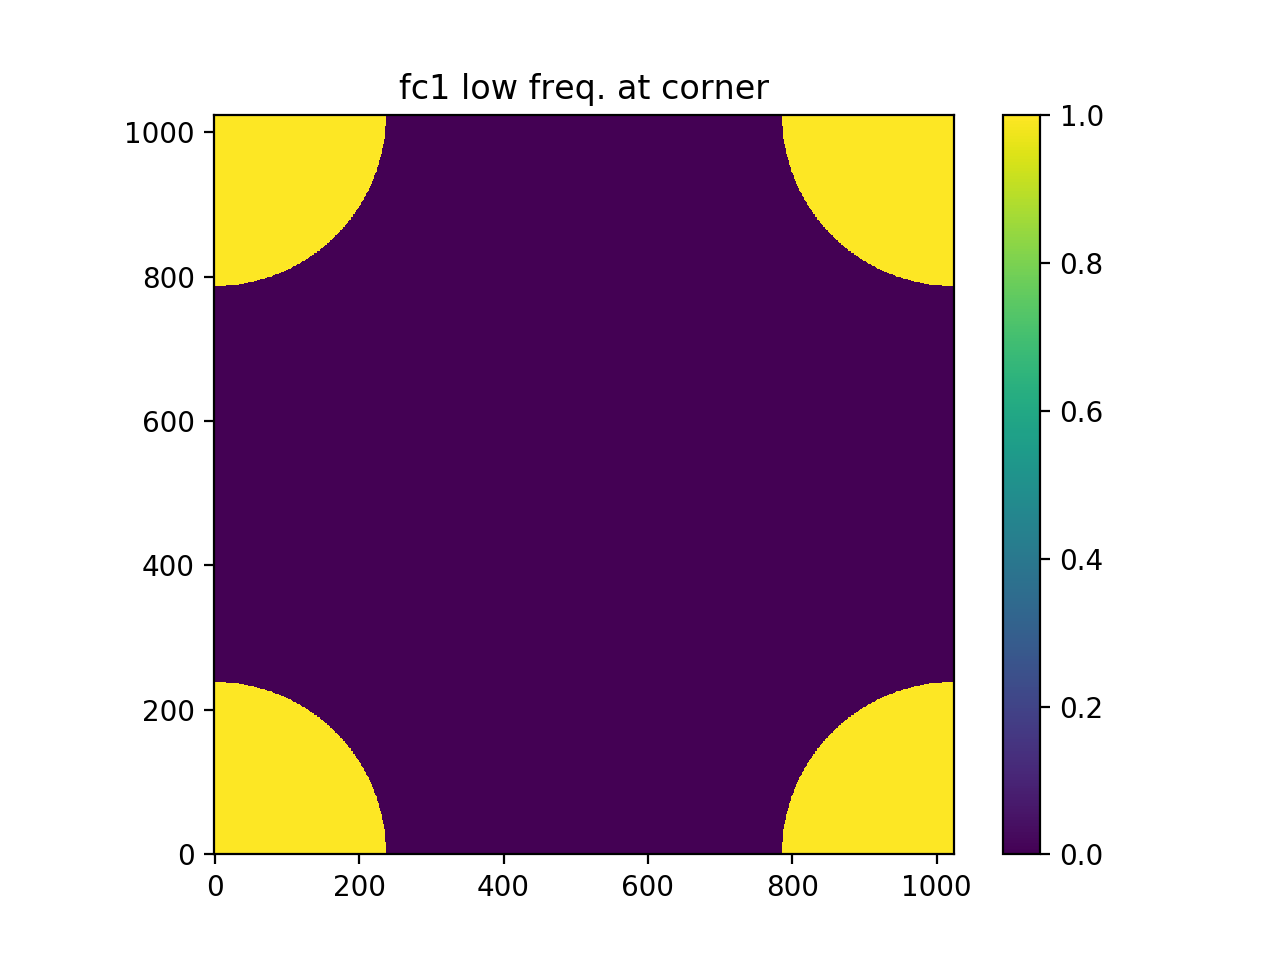

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(np.asarray(freqFlt1, dtype=int), origin='bottom', interpolation='none')
ax1.set_title("fc1 low freq. at corner")
fig.colorbar(cs)

In [17]:
print(flim1)

0.08042965380459527


In [18]:
freqFlt1 = np.logical_not(freqFlt1)
# fc1.real[freqFlt1] = 1./np.sqrt(varMean1)
fc1[freqFlt1] = flim1

<IPython.core.display.Javascript object>


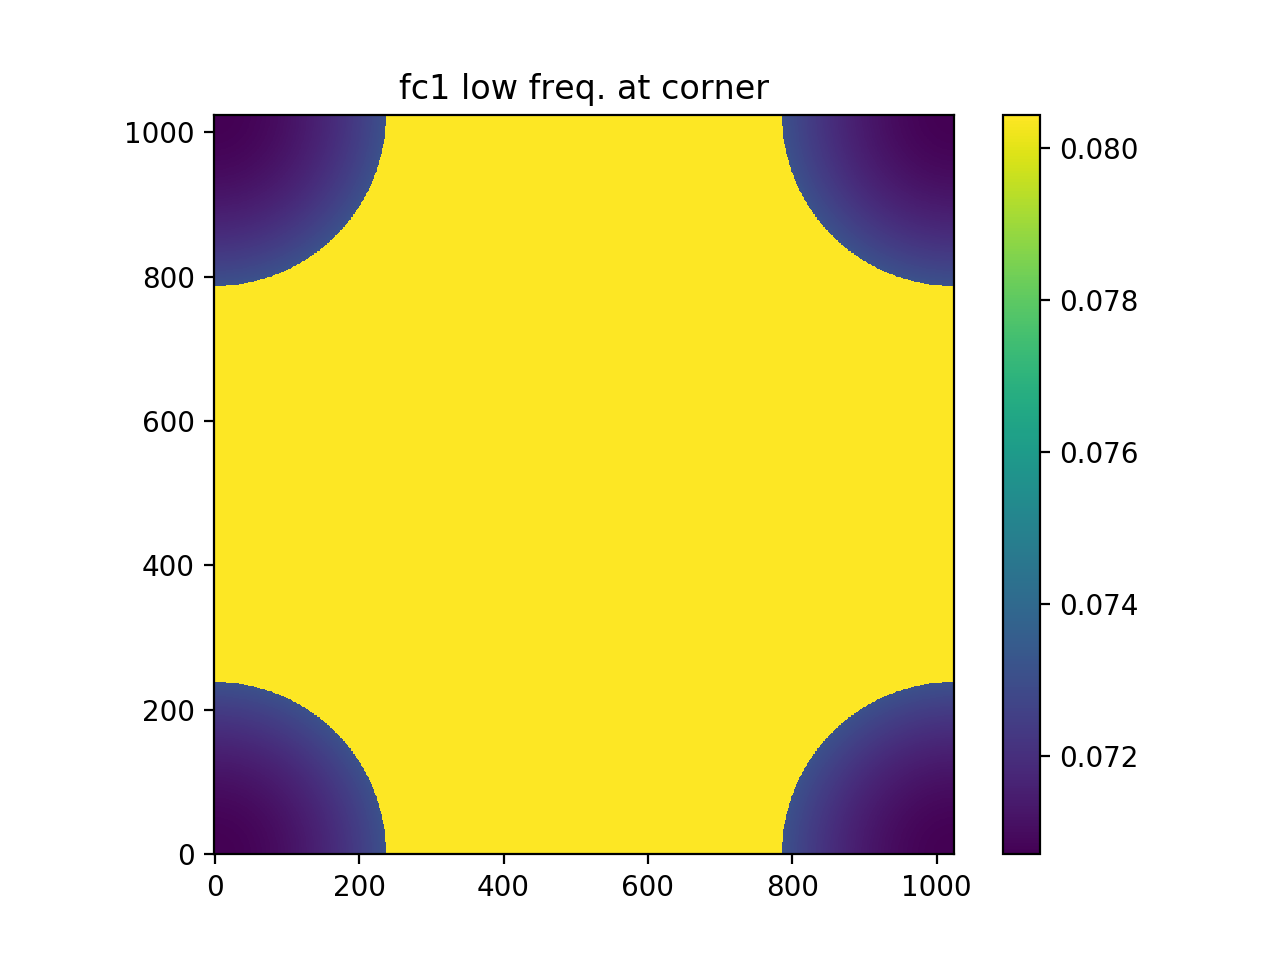

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc1.real, origin='bottom', interpolation='none')
ax1.set_title("fc1 low freq. at corner")
fig.colorbar(cs)

The matching kernel for the narrower input PSF

<IPython.core.display.Javascript object>


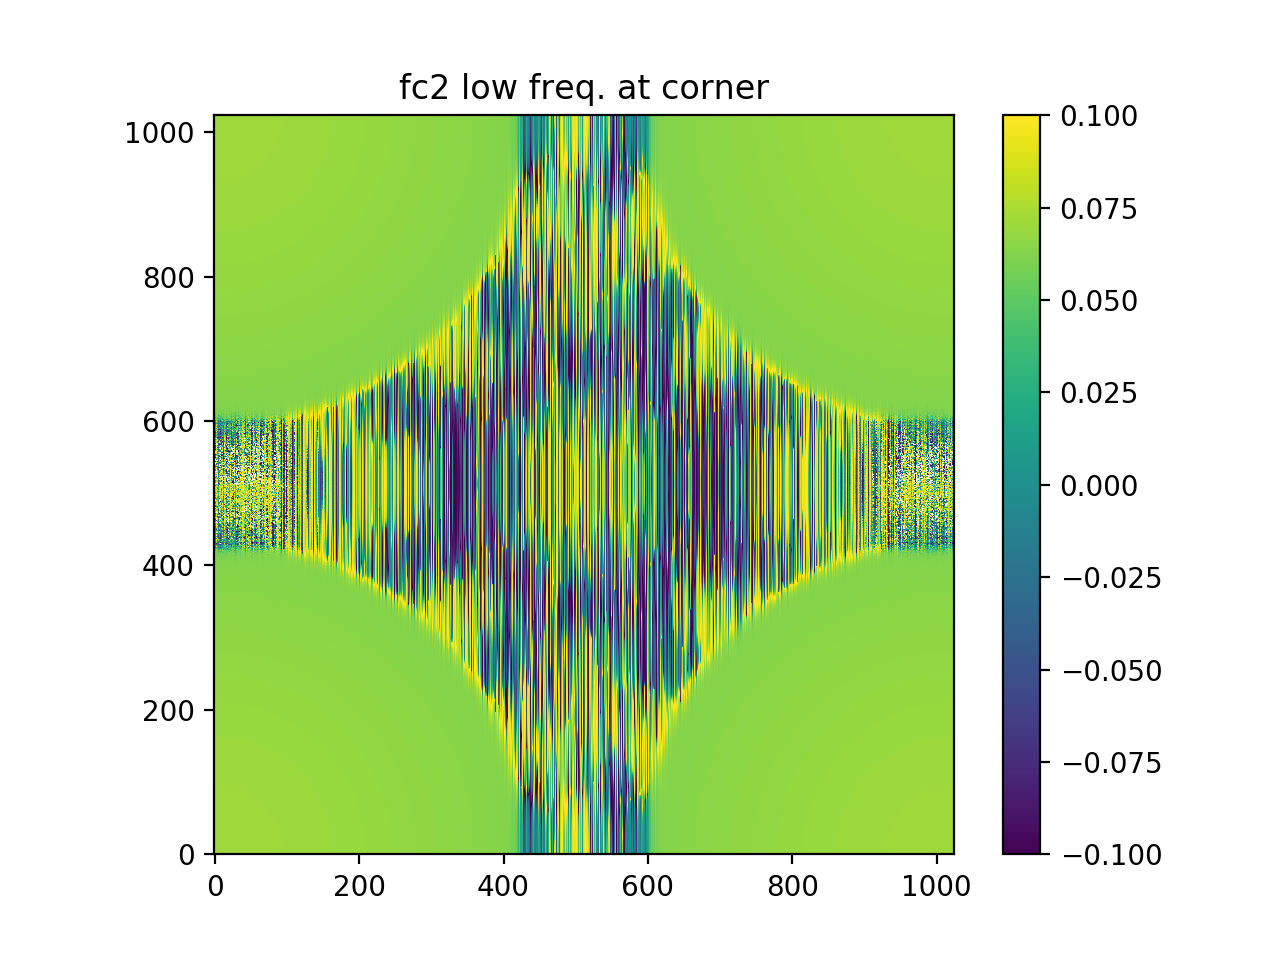

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc2.real, origin='bottom', interpolation='none')
ax1.set_title("fc2 low freq. at corner")
fig.colorbar(cs)

In [22]:
r = np.minimum(fr2, frp1)
rN = np.minimum(fr2, frp1) * 1024
freqFlt2 = makeEllipseQuartersMaskArray((1024, 1024), rN , rN)
flim2 = 1./(F2 * np.sqrt(varMean2/(F2*F2) + varMean1/(F1*F1) * np.exp(fourPiSq*sqDiffWidth*r)))

In [23]:
print(r, flim2)

0.232 0.05942281370713568


<IPython.core.display.Javascript object>


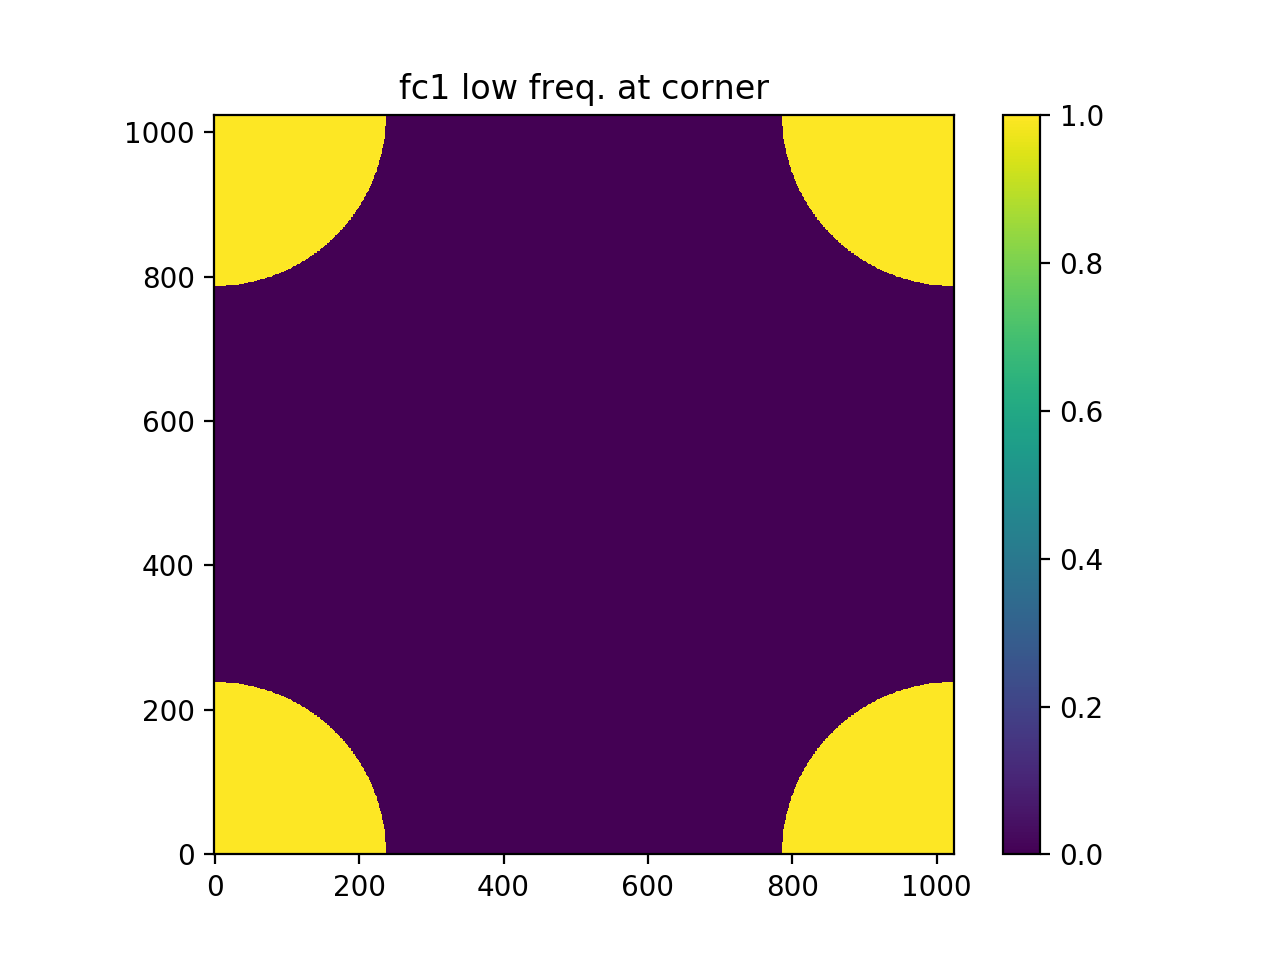

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(np.asarray(freqFlt2, dtype=int), origin='bottom', interpolation='none')
ax1.set_title("fc1 low freq. at corner")
fig.colorbar(cs)

In [25]:
freqFlt2 = np.logical_not(freqFlt2)
#fc2.real[freqFlt2] = 0.
fc2[freqFlt2] = flim2

<IPython.core.display.Javascript object>


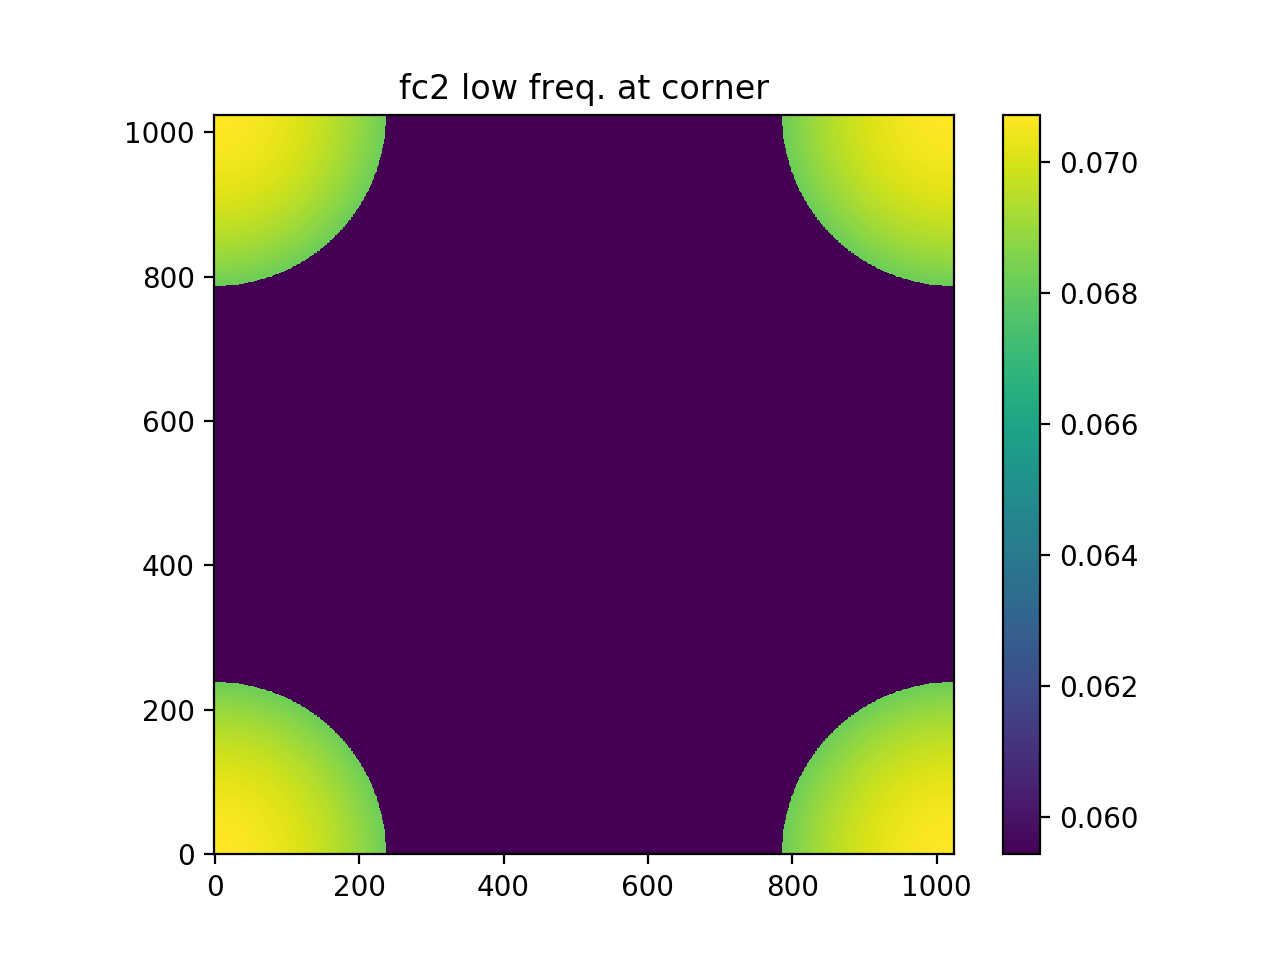

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
cs = ax1.imshow(fc2.real, origin='bottom', interpolation='none')
ax1.set_title("fc2 low freq. at corner")
fig.colorbar(cs)

In [27]:
Pd = np.real(np.fft.ifft2(fPd))
c1 = np.real(np.fft.ifft2(fc1))
c2 = np.real(np.fft.ifft2(fc2))

The matching kernel for the wider input back in image space

<IPython.core.display.Javascript object>


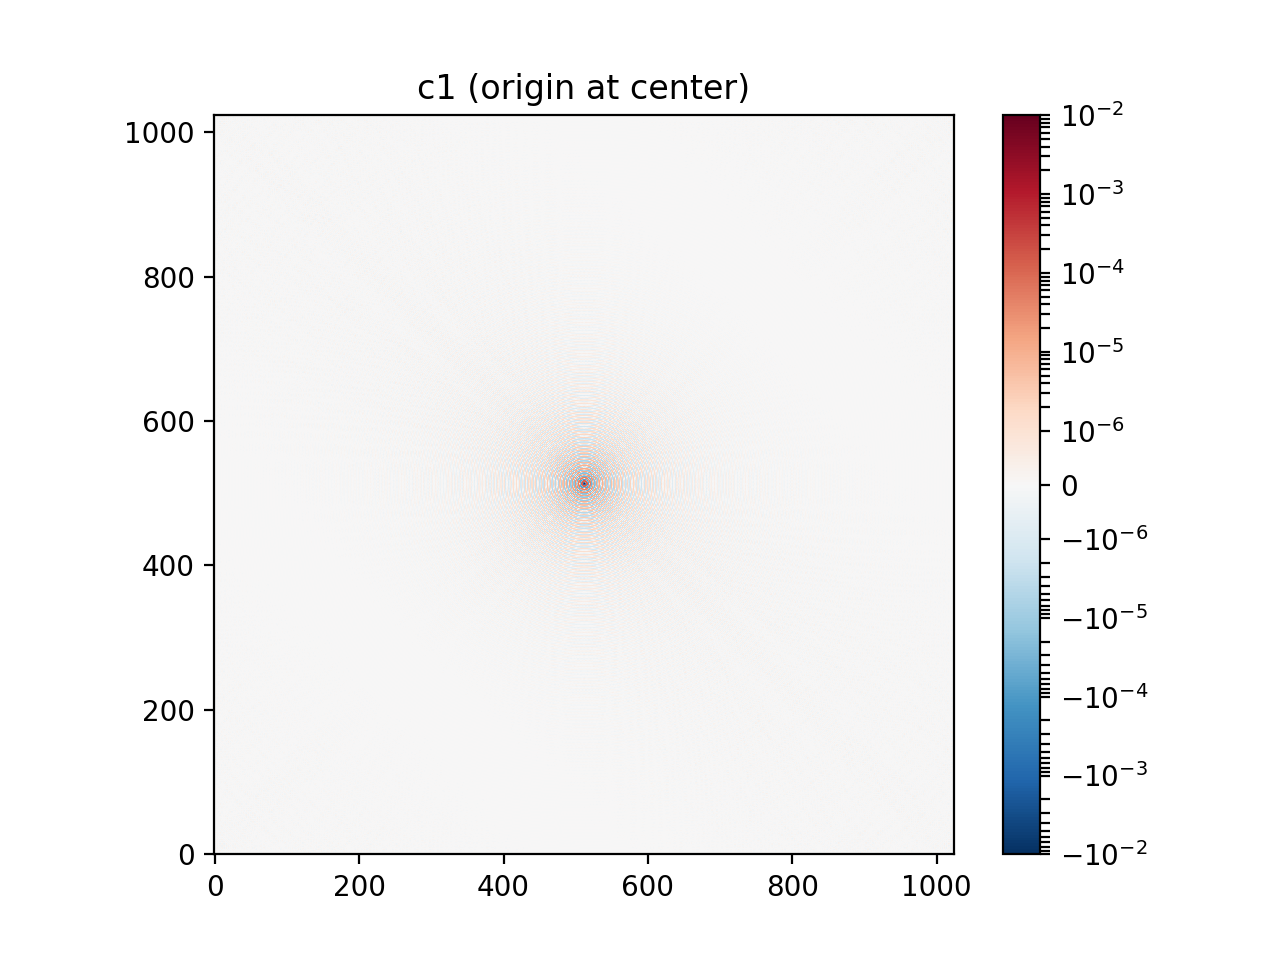

Text(0.5, 1.0, 'c1 (origin at center)')

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(c1, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='bottom', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("c1 (origin at center)")

And for the narrower one

<IPython.core.display.Javascript object>


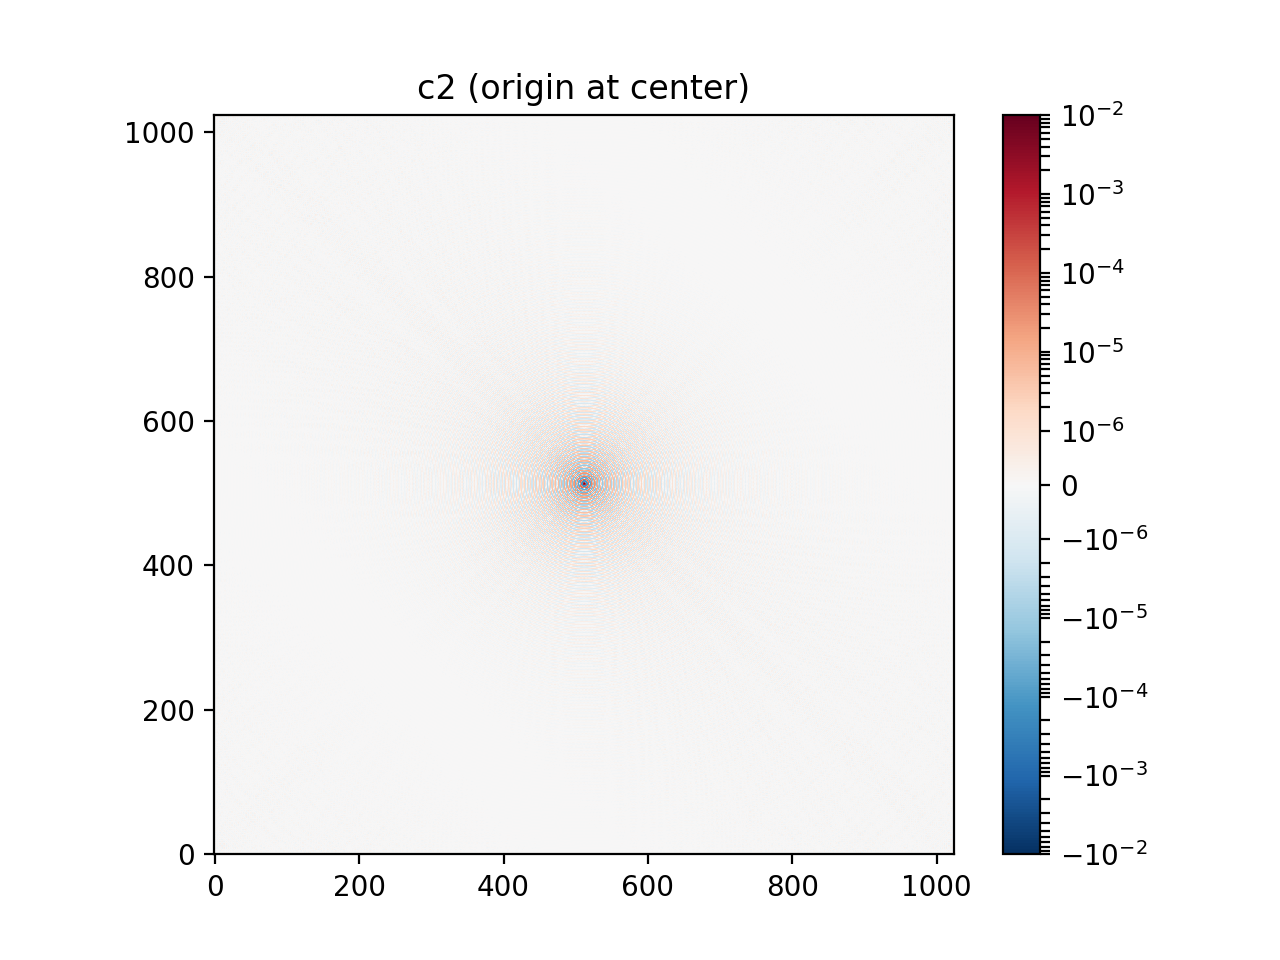

Text(0.5, 1.0, 'c2 (origin at center)')

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
P2 = task.padCenterOriginArray(c2, (1024,1024), useInverse=True)
cs = ax.imshow(P2, interpolation='none', origin='bottom', cmap='RdBu_r',
               norm=matplotlib.colors.SymLogNorm(linthresh=1e-6,vmin=-0.01,vmax=0.01))
fig.colorbar(cs)
ax.set_title("c2 (origin at center)")